In [1]:
import tensorflow as tf

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output

In [20]:
XDIM = 1
HDIM = 4
YDIM = 1

if 'sess' in globals():
    sess.close()
    
sess = tf.InteractiveSession()

def weight(shape):
    return tf.Variable(tf.random_normal(shape))

def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))


is_real = tf.placeholder(tf.int32, shape=[], name="is_real")

xreal = tf.placeholder(tf.float32, shape=[1, 1], name="xreal")

# generator

z = tf.placeholder(tf.float32, shape=[1, 1], name="z")

gW1 = weight([1, 1])
gb1 = bias([1])

gx = tf.matmul(z, gW1) + gb1

# net

x = tf.cond(is_real > 0, lambda: xreal, lambda: gx, name="x")

# discriminator

W1 = weight([1, 4])
b1 = bias([4])

h1 = tf.nn.tanh(tf.matmul(x, W1) + b1)

W2 = weight([4, 1])
b2 = bias([1])
y = tf.nn.sigmoid(tf.matmul(h1, W2) + b2)

t = tf.placeholder(tf.float32, shape=[1, 1], name="t")

cost_discrim = tf.square(y - t)

cost_gen = tf.square(y - 1)

train_discrim = tf.train.GradientDescentOptimizer(0.02).minimize(cost_discrim, var_list=[W1, b1, W2, b2])
train_gen = tf.train.GradientDescentOptimizer(0.02).minimize(cost_gen, var_list=[gW1, gb1])

sess.run(tf.initialize_all_variables())

In [21]:
def real_data():
    return np.random.randn() * .2 -.5

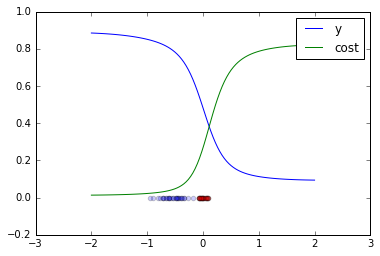

In [22]:
# graph y as fn of x

def vis():
    domain = np.linspace(-2, 2, 100)
    ys = [y.eval(feed_dict={x: [[xx]], is_real: 1})[0, 0] for xx in domain]
    
    real = [real_data() for __ in range(30)]
    fake = [gx.eval(feed_dict={z: [[np.random.random_sample()]], is_real: 0}) for __ in range(len(real))]
    
    cost_discrims = [cost_discrim.eval(feed_dict={x: [[xx]], t: [[1]], is_real: 1})[0, 0] for xx in domain]
    
    pl_disc, = plt.plot(domain, ys, label='y')
    pl_cost, = plt.plot(domain, cost_discrims, label='cost')
    plt.scatter(real, np.zeros(len(real)), c='b', alpha=0.2)
    plt.scatter(fake, np.zeros(len(real)), c='r', alpha=0.2)
    plt.legend(handles=[pl_disc, pl_cost])
    

    
vis()

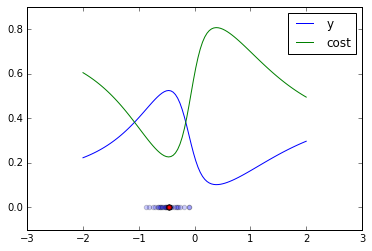

In [34]:
# train on real data

for i in range(800):
    # real datapoint
    _x = [[real_data()]]
    
    should_train_discrim = np.random.randint(0, 2)
    
    if should_train_discrim:
        _real = np.random.randint(0, 2)
        sess.run(train_discrim, feed_dict={xreal: _x, t: [[_real]], z: np.random.random_sample([1, 1]), is_real: _real})
    else:
        # train gen
        sess.run(train_gen, feed_dict={xreal: _x, t: [[_real]], z: np.random.random_sample([1, 1]), is_real: 0})
        
    if i % 50 == 0:
        clear_output(wait=True)
        vis()
        plt.show()